FASTAI 4 DEM - SRCNN with ResBlock
=========================
**This is only a template, no better results could be achieved than with a simple bicubic upsampling.**

If you achieve any proper results please get in contact.

The implementation is based on  https://github.com/benymd/super_resolution and https://github.com/hiromis/notes/blob/master/refactored_by_topics/CNN_L7_resnet.md

# Data

Download the training and test data of the austrian DTM: https://www.openmaps.online/data/austria_dtm_fastai.zip

License: Data by - Geoland.at (2019) - CC BY 4.0 (CC BY 4.0)

High resolution images: 300*300px

Low resolution image: 100*100px

Upsampled to 300*300px with next neighbor or bicubic method


# Setup

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
!pip install rasterio

# Data Loader

In [3]:
# adapt this parameter to the maximum height of your training dataset
max_height = 3150
# adapt the folder name to the low resolution images 
LR_PATH_TRAIN = "/content/gdrive/MyDrive/fastai/data_100/lr_us_cc"

In [4]:
# read geotiffs
import rasterio
from fastbook import *
from fastai.vision import *

def raster2tensor(image):  
    f = rasterio.open(image)
    d1 = f.read(1)
    tensorImage = TensorImage([d1])
    # adapt 
    tensorImage = tensorImage / max_height
    return tensorImage

def raster2tensorHr(image):  
    # adapt to replace the folder name to the high resolution images 
    image = str(image).replace("lr_us_cc", "hr")
    f = rasterio.open(image)
    d1 = f.read(1)
    tensorImage = TensorImage([d1])
    tensorImage = tensorImage / max_height
    return tensorImage 

In [5]:
# valid_pct = percent of the total images that is used for validation 
db = DataBlock(blocks=(TransformBlock(type_tfms=raster2tensor),
                       TransformBlock(type_tfms=raster2tensorHr),
                      ),
               get_items = get_image_files,
               splitter=RandomSplitter(valid_pct=0.1, seed = 42)
              )

In [6]:
dls = db.dataloaders(source=LR_PATH_TRAIN, bs=12, num_workers=2)

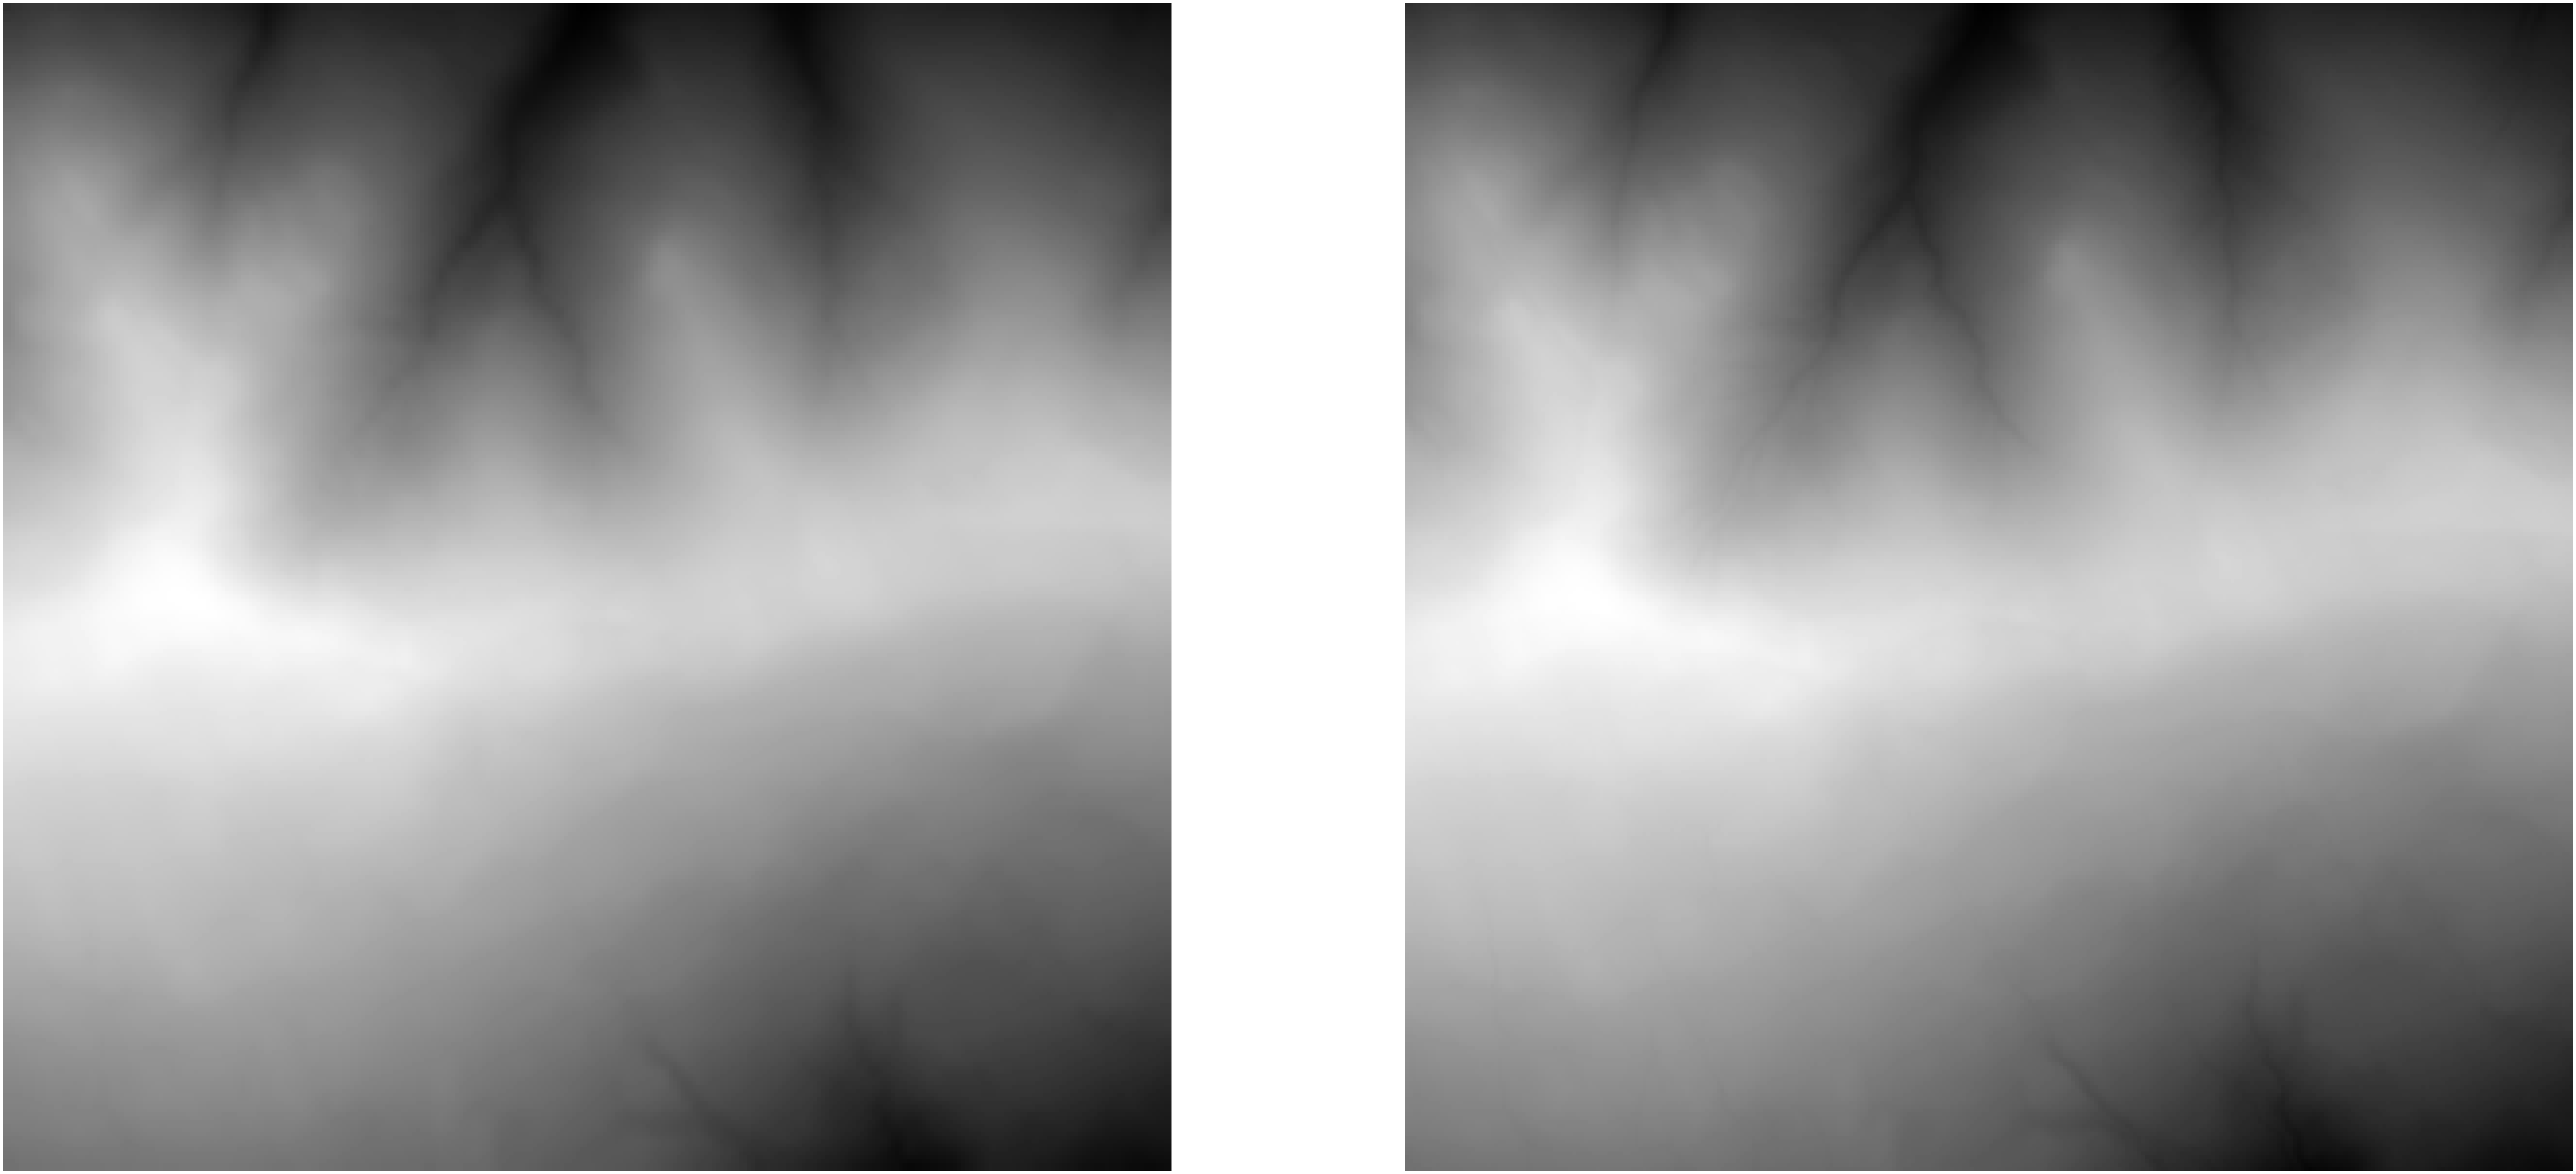

In [ ]:
# Batch is ok, but sometimes it is hard to see the diffences
dls.show_batch(max_n = 1, cmap='gray', figsize = (100,100))

In [ ]:
# Shows the values, got the right datasets
dls.one_batch()

(TensorImage([[[[0.3222, 0.3222, 0.3246,  ..., 0.2698, 0.2679, 0.2679],
           [0.3222, 0.3222, 0.3246,  ..., 0.2698, 0.2679, 0.2679],
           [0.3184, 0.3184, 0.3204,  ..., 0.2700, 0.2681, 0.2681],
           ...,
           [0.3295, 0.3295, 0.3286,  ..., 0.3415, 0.3417, 0.3417],
           [0.3289, 0.3289, 0.3281,  ..., 0.3429, 0.3432, 0.3432],
           [0.3289, 0.3289, 0.3281,  ..., 0.3429, 0.3432, 0.3432]]],
 
 
         [[[0.3957, 0.3957, 0.3939,  ..., 0.3104, 0.3121, 0.3121],
           [0.3957, 0.3957, 0.3939,  ..., 0.3104, 0.3121, 0.3121],
           [0.3950, 0.3950, 0.3932,  ..., 0.3124, 0.3136, 0.3136],
           ...,
           [0.1888, 0.1888, 0.1893,  ..., 0.2171, 0.2173, 0.2173],
           [0.1879, 0.1879, 0.1883,  ..., 0.2158, 0.2160, 0.2160],
           [0.1879, 0.1879, 0.1883,  ..., 0.2158, 0.2160, 0.2160]]],
 
 
         [[[0.5629, 0.5629, 0.5640,  ..., 0.6342, 0.6338, 0.6338],
           [0.5629, 0.5629, 0.5640,  ..., 0.6342, 0.6338, 0.6338],
           [0

# Random

In [7]:
# Taming the random

import random
import numpy as np
import torch

from fastai.vision import *


def set_seeds():
    random.seed(42)
    np.random.seed(12345)
    torch.manual_seed(1234)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()    

# SRCNN Simple with ResBlock

In [8]:
from fastai import *
from fastai.vision import *

class ResBlock(Module):
  def __init__(self, nf):
    self.conv1 = ConvLayer(nf, nf)
    self.conv2 = ConvLayer(nf, nf)
  
  def forward(self, x): return x + self.conv2(self.conv1(x))

model = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, stride=1, padding=9//2),
          ResBlock(64),
          nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0//2),
          ResBlock(32),
          nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=3//2),
          ResBlock(1),
          nn.ReLU()         
        )


  

learn = Learner(dls, model, loss_func = nn.MSELoss(), metrics=mae)

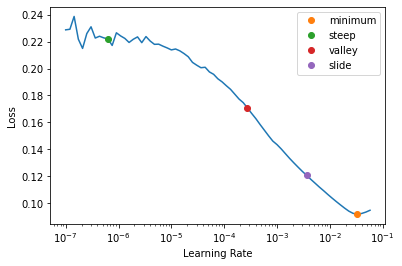

In [9]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [10]:
lr = lrs.valley
lrs = slice(lr)
# a lots of epochs are needed for proper results 
epoch = 10

epoch,train_loss,valid_loss,mae,time
0,0.147358,0.212433,0.421332,00:12
1,0.100590,0.008125,0.063184,00:04
2,0.070769,0.009910,0.054042,00:04
3,0.054121,0.012788,0.057022,00:04
4,0.043709,0.014626,0.061163,00:04
5,0.037154,0.018592,0.066019,00:05
6,0.031799,0.019479,0.061377,00:04
7,0.027582,0.018604,0.059152,00:04
8,0.024409,0.016423,0.066500,00:04
9,0.021888,0.014140,0.055954,00:04


Better model found at epoch 0 with valid_loss value: 0.2124331295490265.


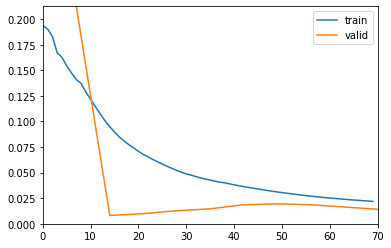

Better model found at epoch 1 with valid_loss value: 0.008125454187393188.


In [11]:
# load - adapt path and name
#learn.load("/content/gdrive/MyDrive/fastai/filename.pth")
learn.fit_one_cycle(epoch, cbs=[ShowGraphCallback(), SaveModelCallback])
# save - adapt path and name
#learn.save("/content/gdrive/MyDrive/fastai/filename.pth") 

# Stats with independent test images

In [12]:
import os
import sys
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
import rasterio
from rasterio.plot import reshape_as_image, reshape_as_raster, show
from rasterio import Affine
from rasterio.enums import Resampling
from numpy import savetxt

# adapt this parameter to the maximum height of your training dataset for PSNR processing
max_height = 3150

# adapt paths
path_lr = '/content/gdrive/MyDrive/fastai/data_test_100/lr_us_cc'
path_hr = '/content/gdrive/MyDrive/fastai/data_test_100/hr'

meanAbsoluteError = []
meanAbsoluteErrorCubic = []

countMAE = 0
countRMSE = 0
countPSNR = 0
countSSI = 0
countMAESlice = 0
countRMSESlice = 0
countPSNRSlice = 0
countSSISlice = 0
totalMAE_lr = 0
totalMAE_sr = 0
totalRMSE_lr = 0
totalRMSE_sr = 0
totalMAX_lr = 0
totalMAX_sr = 0
fileCounter = 0 

# read low resolution images
for file in os.listdir(path_lr):  
    current = os.path.join(path_lr, file)
    fileCounter += 1;
    x, y = [], []
    with rasterio.open(current) as src:
        arrayLR = src.read(
            out_shape=(
                src.count,
                int(src.height),
                int(src.width)
            )
        )        
    max_val_lr = np.amax(arrayLR)
    min_val_lr = np.amin(arrayLR)
    arrayLR = reshape_as_image(arrayLR)
    nsamples, nx, ny = arrayLR.shape
    arrayLR = arrayLR.reshape((nsamples,nx*ny))
   
    f = rasterio.open(current)
    d1 = f.read(1)
    tensorImage = TensorImage([d1])
    tensorImage = (tensorImage - min_val_lr) / (max_val_lr - min_val_lr)
    arraySR = learn.predict(tensorImage)
    arraySR = arraySR[0].numpy()

    # recalculate real world values for sr image
    arraySR = arraySR * (max_val_lr - min_val_lr) + min_val_lr
    arraySR = np.squeeze(arraySR, axis=0)
   
    # maximal value of sr image    
    max_val_sr = np.amax(arraySR)

    # load hr image to compare images    
    currentHr = os.path.join(path_hr, file)
    with rasterio.open(currentHr) as src:
        arrayHR = src.read(
            out_shape=(
                src.count,
                int(src.height),
                int(src.width)
            )
        )
 
    arrayHR = reshape_as_image(arrayHR)
    nsamples, nx, ny = arrayHR.shape
    arrayHR = arrayHR.reshape((nsamples,nx*ny))

    # slice 15 pixels from border because border effects
    slice_val = 15
    HrSlice = arrayHR[slice_val:-slice_val, slice_val:-slice_val]
    SrSlice = arraySR[slice_val:-slice_val, slice_val:-slice_val]
    LrSlice = arrayLR[slice_val:-slice_val, slice_val:-slice_val]
    
    # calculate the metrics for sr image
    MAE_sr = mean_absolute_error(arrayHR, arraySR)
    RMSE_sr = mean_squared_error(arrayHR, arraySR, squared=False)
    SSI_sr = structural_similarity(arrayHR, arraySR)
    MAE_sr_slice = mean_absolute_error(HrSlice, SrSlice)
    RMSE_sr_slice = mean_squared_error(HrSlice, SrSlice, squared=False)
    SSI_sr_slice = structural_similarity(HrSlice, SrSlice)
    MAX_sr = np.amax(abs(arrayHR - arraySR))
    MAX_sr_slice = np.amax(abs(HrSlice - SrSlice))
    # adapt data_range to the maximal overall value  of the dataset
    PSNR_sr = peak_signal_noise_ratio(arrayHR, arraySR, data_range=max_height)
    PSNR_sr_slice = peak_signal_noise_ratio(HrSlice, SrSlice, data_range=max_height)
    
    # calculate the metrics for lr image
    MAE_lr = mean_absolute_error(arrayHR, arrayLR)
    RMSE_lr = mean_squared_error(arrayHR, arrayLR, squared=False)
    SSI_lr = structural_similarity(arrayHR, arrayLR)
    MAE_lr_slice = mean_absolute_error(HrSlice, LrSlice)
    RMSE_lr_slice = mean_squared_error(HrSlice, LrSlice, squared=False)
    SSI_lr_slice = structural_similarity(HrSlice, LrSlice)
    MAX_lr = np.amax(abs(arrayHR - arrayLR))
    MAX_lr_slice = np.amax(abs(HrSlice - LrSlice))
    # adapt data_range to the maximal overall value  of the dataset
    PSNR_lr = peak_signal_noise_ratio(arrayHR, arrayLR, data_range=max_height)
    PSNR_lr_slice = peak_signal_noise_ratio(HrSlice, LrSlice, data_range=max_height)
    
    # MAE count improved images
    if MAE_sr < MAE_lr:
        countMAE += 1
    if MAE_sr_slice < MAE_lr_slice:
        countMAESlice += 1    
    # RMSE count improved images
    if RMSE_sr < RMSE_lr:
        countRMSE += 1
    if RMSE_sr_slice < RMSE_lr_slice:
        countRMSESlice += 1 
    # PSNR count imporved images, higher values are better
    if PSNR_sr > PSNR_lr:
        countPSNR += 1
    if PSNR_sr_slice > PSNR_lr_slice:
        countPSNRSlice += 1    
    # SSI count imporved images, higher values are better
    if SSI_sr > SSI_lr:
        countSSI += 1
    if SSI_sr_slice > SSI_lr_slice:
        countSSISlice += 1

    totalMAE_lr = totalMAE_lr + MAE_lr_slice
    totalMAE_sr = totalMAE_sr + MAE_sr_slice
    totalRMSE_lr = totalRMSE_lr + RMSE_lr_slice
    totalRMSE_sr = totalRMSE_sr + RMSE_sr_slice        
    totalMAX_lr = totalMAX_lr + MAX_lr_slice
    totalMAX_sr = totalMAX_sr + MAX_sr_slice 

    # print metrics for every tile if desired
    #print(file ,' SR MaxError: ', MAX_sr_slice  ,' LR MaxError: ', MAX_lr_slice, ' Difference MaxError LR - SR: ', MAX_lr_slice - MAX_sr_slice)
    #print(file ,' SR MAE: ', MAE_sr_slice ,' LR MAE: ', MAE_lr_slice, ' Difference LR - SR: ', MAE_lr_slice - MAE_sr_slice)
    #print(file ,' SR RMSE: ', RMSE_sr_slice ,' LR RMSE: ', RMSE_lr_slice, ' Difference LR - SR: ', RMSE_lr_slice - RMSE_sr_slice)
    #print(file ,' SR PSNR: ', PSNR_sr_slice ,' LR PSNR: ', PSNR_lr_slice, ' Difference LR - SR: ', PSNR_lr_slice - PSNR_sr_slice)

print('Mean MAE LR', totalMAE_lr/fileCounter);
print('Mean MAE SR', totalMAE_sr/fileCounter);
print('Difference LR - SR MAE ', totalMAE_lr/fileCounter - totalMAE_sr/fileCounter)
print('Mean RMSE LR', totalRMSE_lr/fileCounter);
print('Mean RMSE SR', totalRMSE_sr/fileCounter);
print('Difference SR - LR RMSE ', totalRMSE_lr/fileCounter - totalRMSE_sr/fileCounter)
print('MAX LR', totalMAX_lr/fileCounter);
print('MAX SR', totalMAX_sr/fileCounter);
print('Difference LR - SR MAX ', totalMAX_lr/fileCounter - totalMAX_sr/fileCounter)

Mean MAE LR 2.63192657828331
Mean MAE SR 69.54290273666382
Difference LR - SR MAE  -66.9109761583805
Mean RMSE LR 3.3373901045322416
Mean RMSE SR 88.37143955230712
Difference SR - LR RMSE  -85.03404944777488
MAX LR 29.542468872070312
MAX SR 313.6396166992188
Difference LR - SR MAX  -284.0971478271485
